In [26]:
from dotenv import load_dotenv
import os
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq

load_dotenv()

model_llm = ChatOpenAI(model='gpt-4o')
model = ChatGroq(model = "qwen/qwen3-32b")
result = model.invoke("Give me a quick one liner")
result

AIMessage(content='<think>\nOkay, the user is asking for a quick one-liner. Let me think about what they might need. They probably want something catchy or memorable. Maybe a quote, a joke, or a motivational line? Since they didn\'t specify the context, I should aim for something universally appealing.\n\nHmm, quotes are always a good bet. Let me recall some famous ones. "Carpe diem" is classic, but maybe too common. How about something from a movie or a book? "May the Force be with you" is good, but again, maybe overused. Maybe a more original line?\n\nThey could be looking for inspiration. Something like "Success is 99% failure and 1% luck" – wait, isn\'t that a twist on Edison\'s quote? Maybe not accurate. Let me check. Edison said something like "Genius is 1% inspiration and 99% perspiration." So flipping that might be creative. But is it okay to alter quotes? Maybe the user wants something original.\n\nAlternatively, a witty one-liner. "The only way to do great work is to love wha

### Custom TOols

In [27]:
def multiply(a:int, b:int)-> int:
    """Multiply a and b
    Args:
    a: first int
    b: second int
    """
    return a*b

def add(a:int, b:int)->int:
    """Add a and b
    Args:
    a: first int
    b: second int
    """
    return a + b

def divide(a:int, b:int)->int:
    """Divide a and b
    Args:
    a: first int
    b: second int
    """
    return a /b

tools = [add, multiply, divide]
tools

[<function __main__.add(a: int, b: int) -> int>,
 <function __main__.multiply(a: int, b: int) -> int>,
 <function __main__.divide(a: int, b: int) -> int>]

In [28]:
models_with_tools = model.bind_tools(tools)

models_with_tools.invoke("whats 12 & 13")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking "whats 12 & 13". Let me figure out what they need. The ampersand here might be a typo for "and", so they probably want to know the result of adding, multiplying, or dividing 12 and 13. Since they didn\'t specify the operation, I should consider the most common ones.\n\nLooking at the available tools, there are functions for add, multiply, and divide. If I assume they want the sum, I can use the add function. But maybe they want the product? Without more context, it\'s hard to tell. However, the user might just be asking for the numbers 12 and 13 as in "what are they?" but that seems less likely. Since they used "whats" followed by two numbers separated by an ampersand, it\'s more likely a math operation. \n\nI should check if there\'s a standard operation for this. In some contexts, "&" can mean multiplication, but usually, it\'s addition. But in math, "&" isn\'t a standard operator. So maybe the us

### Importing Libraries for Langgraph

In [29]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

##System Message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

#node
def assistant(state:MessagesState):
    return {"messages":[models_with_tools.invoke([sys_msg] + state["messages"])]}

#Graph
builder = StateGraph(MessagesState)

#add node
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

#add edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    #if the latest message(result) from the assistant is a tool call -> tools_condition routes to tools
    #if the latest message(result) from assistant is not a tool call -> tools_condition routes to end
    tools_condition,
)

builder.add_edge("tools", "assistant")
memory = MemorySaver()
#builder.compile(interrupt_before=["assistant"],checkpointer=memory)
graph = builder.compile(interrupt_before=["assistant"],checkpointer=memory)

In [30]:
thread = {"configurable":{"thread_id":"123"}}
initial_input = {"messages":HumanMessage(content="Multiply 2 & 5")}

In [31]:
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 & 5


In [32]:
state = graph.get_state(thread)
state.next


('assistant',)

In [33]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 & 5
================================== Ai Message ==================================
Tool Calls:
  multiply (gzy1njyj0)
 Call ID: gzy1njyj0
  Args:
    a: 2
    b: 5
================================= Tool Message =================================
Name: multiply

10


In [34]:
state = graph.get_state(thread)
state.next

('assistant',)

In [35]:
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 & 5', additional_kwargs={}, response_metadata={}, id='c5c9a5a1-54a4-44d0-ae60-84d4dd7f2d84'), AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, the user wants to multiply 2 and 5. Let me check the available functions. There's a multiply function that takes two integers, a and b. So I need to call that. The parameters should be a:2 and b:5. I'll make sure to format the tool call correctly in JSON inside the XML tags.\n", 'tool_calls': [{'id': 'gzy1njyj0', 'function': {'arguments': '{"a":2,"b":5}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 99, 'prompt_tokens': 279, 'total_tokens': 378, 'completion_time': 0.140749563, 'prompt_time': 0.010752387, 'queue_time': 0.012326703999999999, 'total_time': 0.15150195}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_ea13068061', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c524550e-87

In [36]:
initial_input = {"messages":HumanMessage(content="Multiply 3 & 5")}
thread = {"configurable":{"thread_id":"1"}}
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 3 & 5


In [37]:
state = graph.get_state(thread)
state.next

('assistant',)

In [38]:
graph.update_state(thread, {"messages":[HumanMessage(content="No, please multiyp 15 & 8")]})


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f061a54-6190-6097-8001-ad90c3e35e32'}}

In [40]:
new_state = graph.get_state(thread).values

for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 3 & 5
================================ Human Message =================================

No, please multiyp 15 & 8


In [41]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, please multiyp 15 & 8
================================== Ai Message ==================================
Tool Calls:
  multiply (5qgthypej)
 Call ID: 5qgthypej
  Args:
    a: 15
    b: 8
================================= Tool Message =================================
Name: multiply

120


### Workflow to wait for the User Input

In [42]:
#System Message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of input")

##Human Feedback node
def human_feedback(state: MessagesState):
    pass

###Assistant node
def assistant(state:MessagesState):
    return {"messages":[models_with_tools.invoke([sys_msg] + state["messages"])]}

#Graph
builder = StateGraph(MessagesState)

#Add nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)


##Define the edges
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    #If the latest message(result) from assistant is a tool call -> tools_condition routes to tools
    #If the latest message(result) from assistant is not a tool call -> tools_conditions routes to END
    tools_condition,
)

builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)


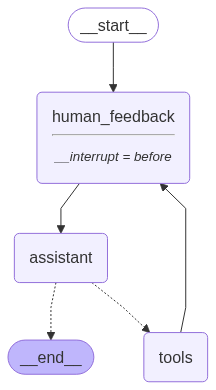

In [43]:
graph

In [45]:
#Input 
initial_input = {"messages":"Multiply 4 & 9"}

#thread
thread = {"configurable":{"thread_id":"5"}}

#Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

#get user input

user_input = input("Tell me how you want to update the state: ")
graph.update_state(thread, {"messages":user_input}, as_node="human_feedback")

for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 4 & 9
================================ Human Message =================================

Multiply 88 and 96
================================== Ai Message ==================================
Tool Calls:
  multiply (qj7wjtyj0)
 Call ID: qj7wjtyj0
  Args:
    a: 88
    b: 96
================================= Tool Message =================================
Name: multiply

8448


In [46]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

8448
================================== Ai Message ==================================

The result of multiplying 88 and 96 is **8448**.
